In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt

from functions import F, mu
from models import OneHiddenNN, TwoHiddenNN

In [42]:
n = 1000

C1  = 1
C2 = 1
C3 = 2

In [43]:
K1 = C1 * n**(1/2)
eps = 1/(C3 * n**(1/2))
f = F(eps, K1)

In [ ]:
def compare_models(model1_class, model2_class, f, mu, n,
                   params_count, epochs, batch_size, lr,
                   runs, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    all_loss1 = []
    all_loss2 = []

    for run in range(runs):
        model1 = model1_class(n, params_count).to(device)
        model2 = model2_class(n, params_count).to(device)
        
        optimizer1 = optim.Adam(model1.parameters(), lr=lr)
        optimizer2 = optim.Adam(model2.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        loss1_list = []
        loss2_list = []
        
        for epoch in range(epochs):
            x = mu(n, batch_size).to(device)
            y = f(x).to(device)

            optimizer1.zero_grad()
            y1 = model1(x)
            loss1 = criterion(y1, y)
            loss1.backward()
            optimizer1.step()

            optimizer2.zero_grad()
            y2 = model2(x)
            loss2 = criterion(y2, y)
            loss2.backward()
            optimizer2.step()
            
            loss1_list.append(loss1.item())
            loss2_list.append(loss2.item())
        
        all_loss1.append(loss1_list)
        all_loss2.append(loss2_list)
    
    all_loss1 = np.array(all_loss1)
    all_loss2 = np.array(all_loss2)
    
    stats = {
        "epochs" : epochs,
        "runs" : runs,
        "Loss1": all_loss1,
        "Loss2": all_loss2,
    }
    
    return stats

def plot_stats(stats):
    epochs = stats["epochs"]
    runs = stats["runs"]
    all_loss1 = stats["Loss1"]
    all_loss2 = stats["Loss2"]
    plt.figure(figsize=(8,5))
    plt.plot(all_loss1.mean(axis=0), label='Model 1 Mean')
    plt.fill_between(range(epochs),
                     all_loss1.mean(axis=0) - all_loss1.std(axis=0),
                     all_loss1.mean(axis=0) + all_loss1.std(axis=0),
                     alpha=0.2)
    plt.plot(all_loss2.mean(axis=0), label='Model 2 Mean')
    plt.fill_between(range(epochs),
                     all_loss2.mean(axis=0) - all_loss2.std(axis=0),
                     all_loss2.mean(axis=0) + all_loss2.std(axis=0),
                     alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Comparison over {runs} runs')
    plt.legend()
    plt.show()


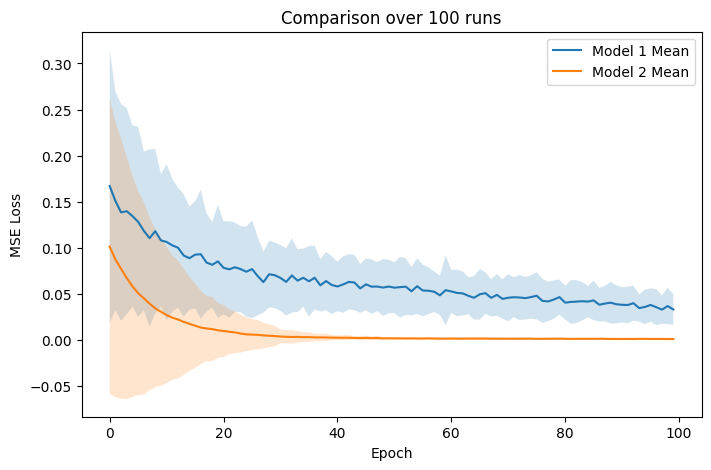

In [48]:
epochs = 100
batch_size = 10

params_count = 2**15

runs = 100

lr = 1e-3

stats = compare_models(OneHiddenNN, TwoHiddenNN, f, mu, n, params_count, epochs, batch_size, lr, runs)
plot_stats(stats)